Goal: to change the diameter of the dendritic arbor to reduce the change in input resistance over the arbor, to subsequently remove passive normalization. 

In [1]:
from pop_mc_model import *

In [2]:
target_neuron = 'local5'
target_body_id = 5813105722
dis_sec_range = (195, 196)
dendr_branchout_sec = 196

In [3]:
cell1, curr_syns, netstim, netcons, num = visualize_inputs(target_neuron, target_body_id, input_name = None)

importing local5 5813105722
One point section Import3d_Section[44] ending at line 75 has been removed
	and child Import3d_Section[45] reattached
	and child Import3d_Section[46] reattached
One point section Import3d_Section[1] ending at line 6 has been removed
	and child Import3d_Section[2] reattached
	and child Import3d_Section[39] reattached
not adding synapses


In [4]:
L1_DIS_diams = []
for i in range(dis_sec_range[0], dis_sec_range[1]):
    L1_DIS_diams.append(cell1.axon[i].diam)
print(f'median {target_neuron} DIS diam: {median(L1_DIS_diams)}')

median local5 DIS diam: 0.9207194426951687


In [5]:
L1_arbor_diams = []
for sec in cell1.axon[dendr_branchout_sec].subtree():
    L1_arbor_diams.append(sec.diam)
print(f'median {target_neuron} arbor diam: {median(L1_arbor_diams)}')

median local5 arbor diam: 0.3352672686095037


In [6]:
%matplotlib notebook
def plot_imp_props(dendr_sec, dendr_seg, col = 'grey', terminal_col = 'seagreen', invfit_col = 'cornflowerblue'):
    '''
        dendr_sec - int: section from which to measure
    '''
    global imps_df
    imps_df = []
    imp = h.Impedance()
    imp.loc(dendr_seg, sec= cell1.axon[dendr_sec])
    imp.compute(0)
    for sec in cell1.axon[dendr_sec].subtree():
        for seg in sec:
            seg_imps = {}
            seg_imps.update(gd=h.distance(cell1.axon[dendr_sec](dendr_seg), seg))
            seg_imps.update(zi=imp.input(seg))
            seg_imps.update(zc=imp.transfer(seg))
            seg_imps.update(k=imp.ratio(seg))
            if len(sec.subtree())==1: seg_imps.update(terminal_sec=True)
            else: seg_imps.update(terminal_sec=False)
            imps_df.append(seg_imps)
    imps_df = pd.DataFrame(imps_df)
            
    fig, axs = plt.subplots(1, 4, figsize = (12, 3))
    
    def scatter(ax, var1, var2, norm=False):
        if norm:
            term = [val/max(imps_df[var2]) for val in  imps_df.loc[imps_df.terminal_sec, var2]]
            non_term = [val/max(imps_df[var2]) for val in  imps_df.loc[~imps_df.terminal_sec, var2]]
        else:
            term = imps_df.loc[imps_df.terminal_sec, var2]
            non_term = imps_df.loc[~imps_df.terminal_sec, var2]
        ax.scatter(imps_df.loc[imps_df.terminal_sec, var1], term, 
                   s = 1, c = terminal_col, alpha=0.5)
        ax.scatter(imps_df.loc[~imps_df.terminal_sec, var1], non_term, 
                   s = 1, c = col, alpha=0.5)
    
    scatter(axs[0], 'gd', 'zi')
    axs[0].set(ylim=(0,4500), ylabel = 'input resistance', xlabel = 'dist from proximal dendritic point')
    
    scatter(axs[1], 'gd', 'k')
    axs[1].set(ylim=(0,1), ylabel = 'transfer ratio', xlabel = 'dist from proximal dendritic point')
    
    norm_zc=True
    if norm_zc: zc_ylim=1
    else: zc_ylim=1500
    scatter(axs[2], 'gd', 'zc', norm=norm_zc)
    axs[2].set(ylim=(0,zc_ylim), ylabel = 'transfer resistance', xlabel = 'dist from proximal dendritic point')
    
    scatter(axs[3], 'k', 'zi')
    # inverse fit:
    inv_coeff = mean([zi_i*k_i for zi_i, k_i in zip(imps_df.zi, imps_df.k)])
    inv_fit = lambda x: inv_coeff/x
    axs[3].plot(np.arange(0.01, 1.05, 0.025), [inv_fit(x) for x in np.arange(0.01, 1.05, 0.025)], 
                c = invfit_col, label = 'inverse fit')
    axs[3].set(ylabel = 'input resistance', xlabel = 'transfer ratio', xlim=(0,1))
    axs[3].legend(frameon = False)
    
    for ax in axs.flatten():
        ax.spines['top'].set_visible(False), ax.spines['right'].set_visible(False)
    
    plt.tight_layout()

<IPython.core.display.Javascript object>


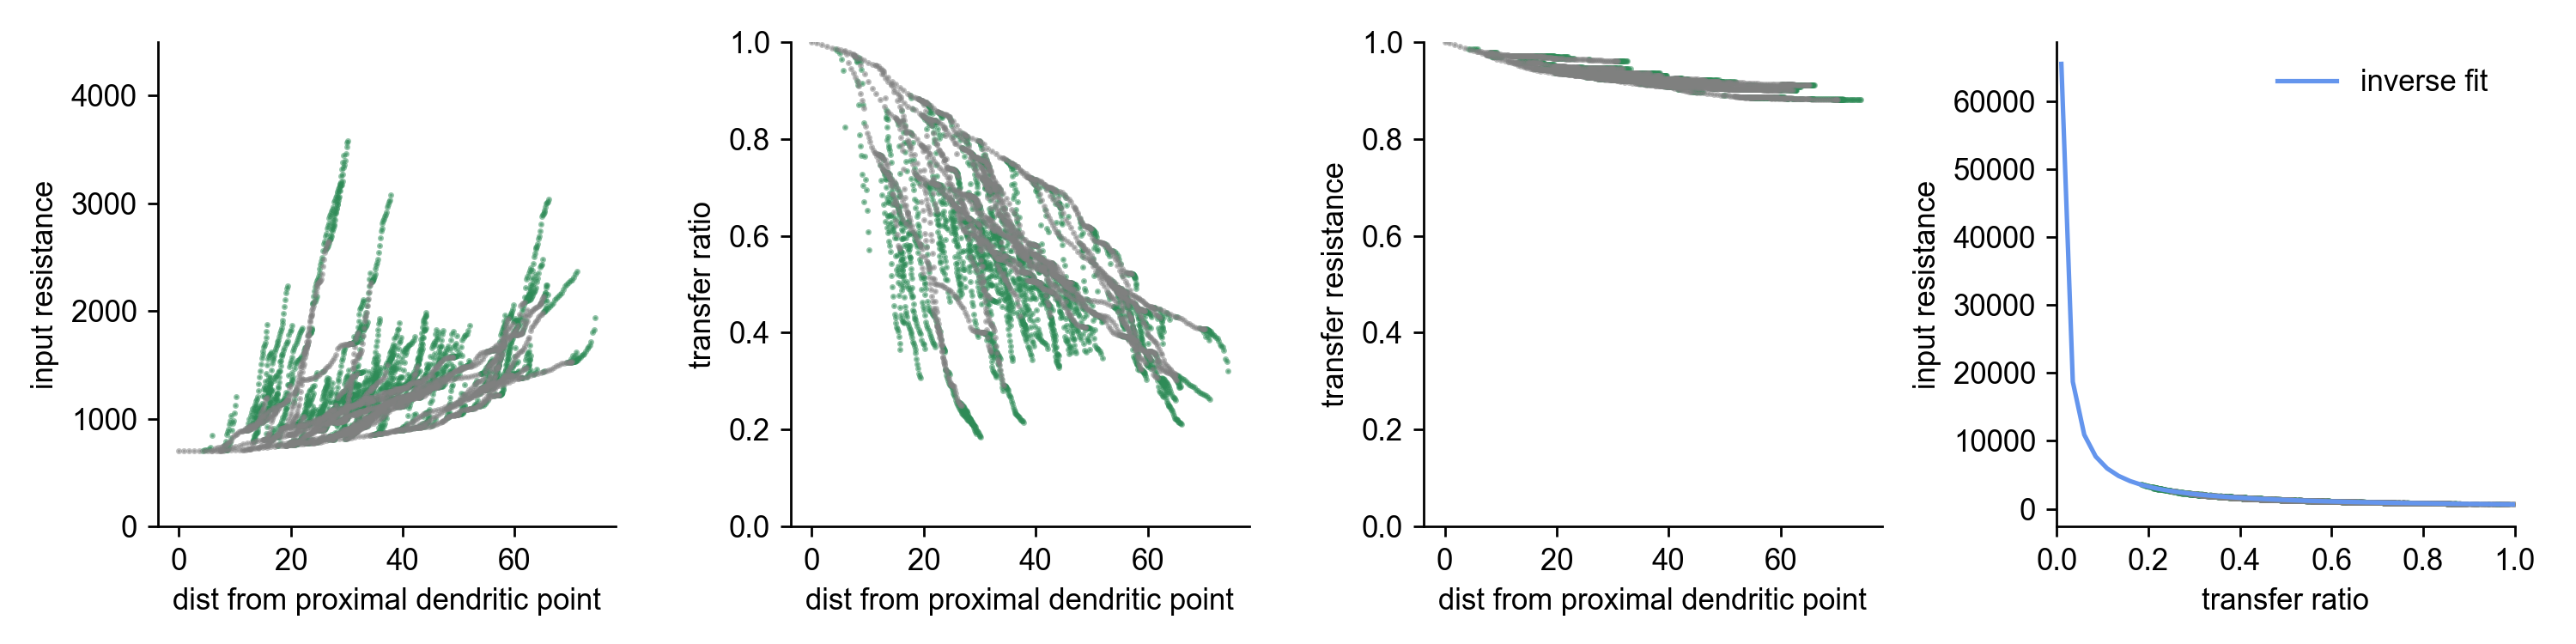

In [7]:
plot_imp_props(dendr_sec = dis_sec_range[0], dendr_seg = 0.1)

<IPython.core.display.Javascript object>


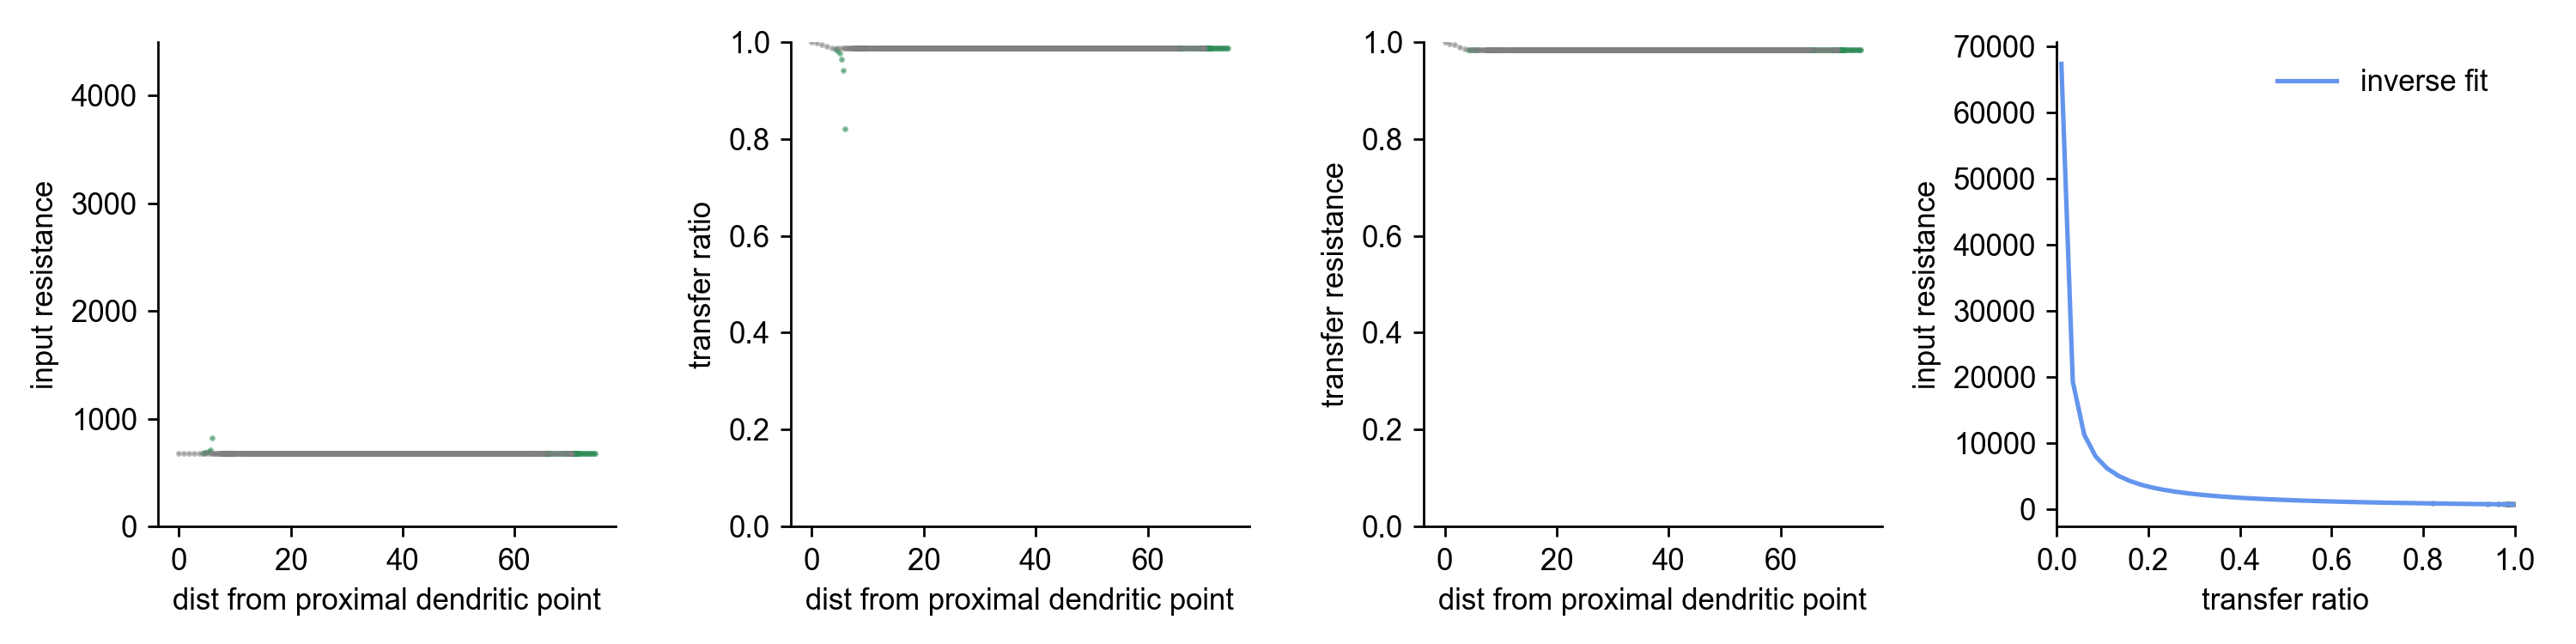

In [8]:
# set dendritic Ra to zero
for sec in cell1.axon[dendr_branchout_sec].subtree():
    sec.Ra = 0.00001
plot_imp_props(dendr_sec = dis_sec_range[0], dendr_seg = 0.1)

<IPython.core.display.Javascript object>


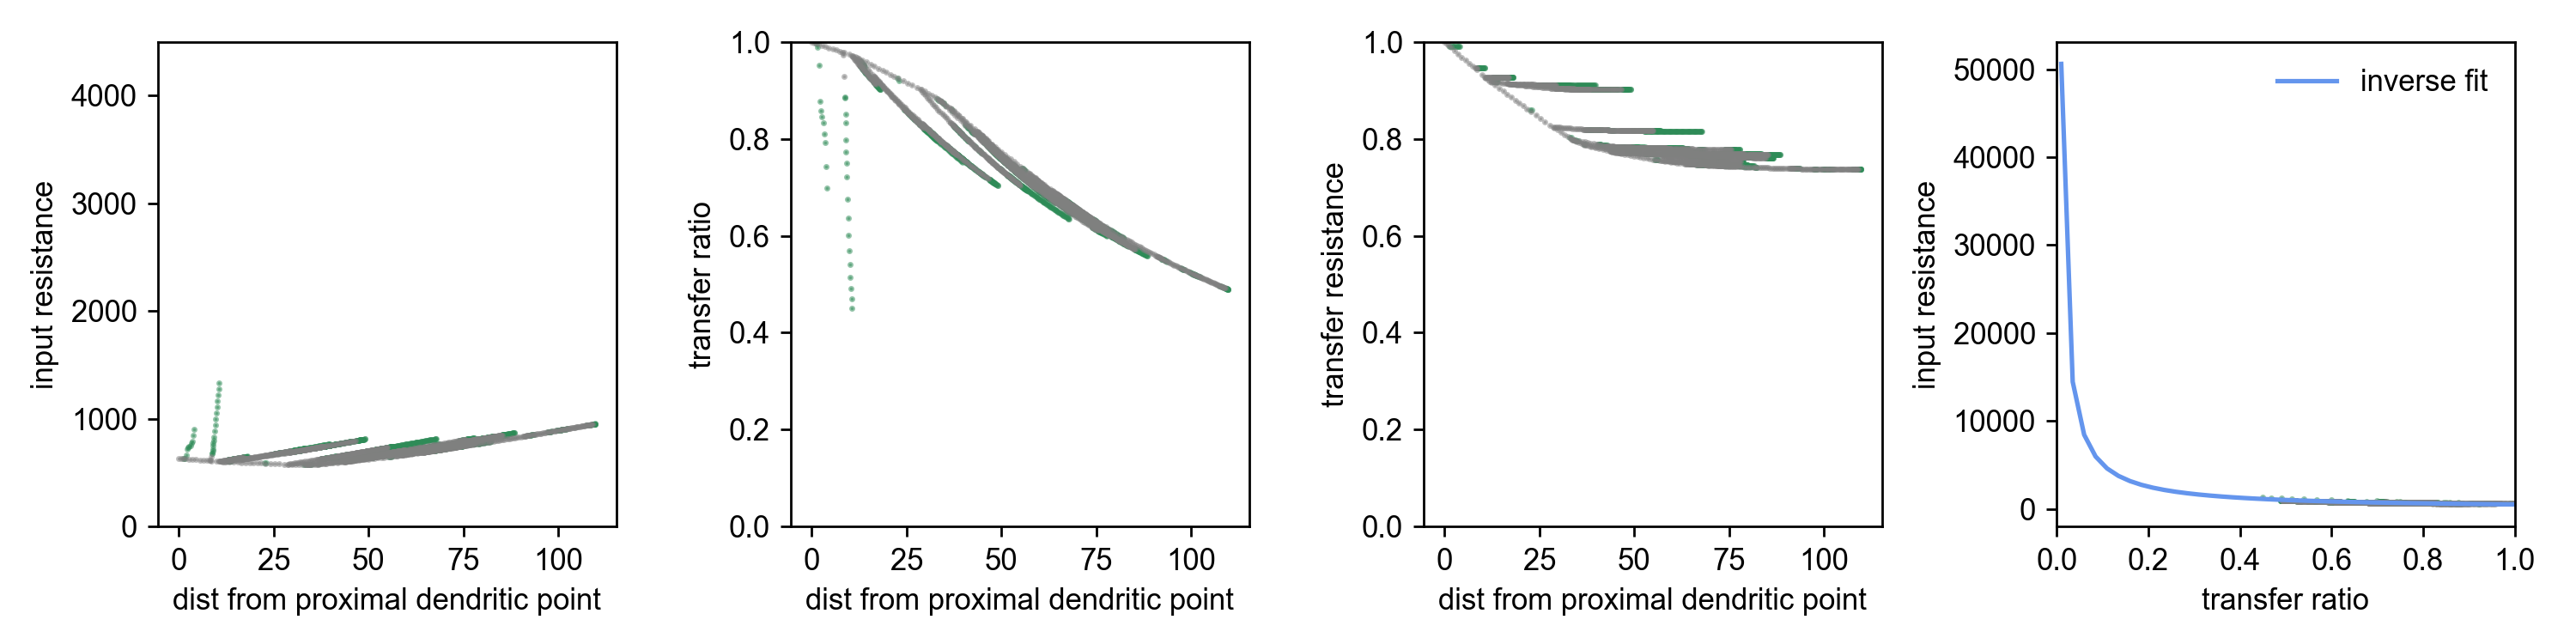

In [8]:
# thicken all dendritic neurites
for sec in cell1.axon[dendr_branchout_sec].subtree():
    sec.diam = median(L1_DIS_diams)
plot_imp_props(dendr_sec = dis_sec_range[0], dendr_seg = 0.1)

ML9 after thickening all dendritic arbor neurites: 
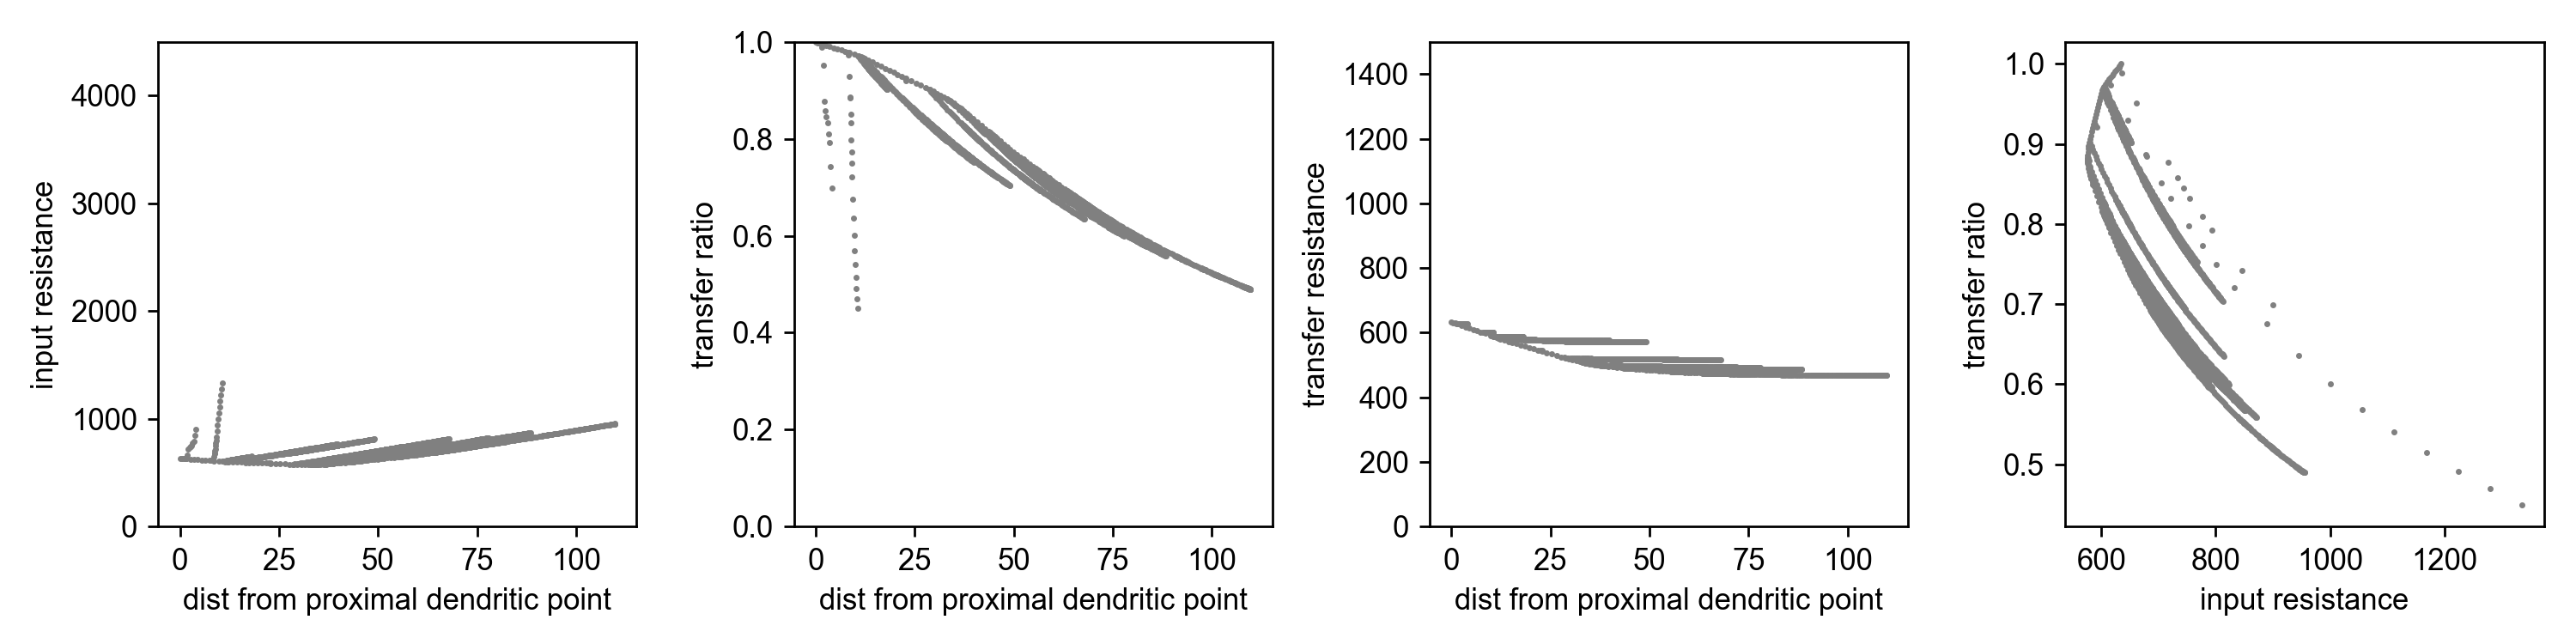

## Understand tapering of neurites

In [9]:
def path_to_parent(sec, ult_root_sec, sub_path):
    sub_path.append(sec)
    if sec == ult_root_sec:
        return sub_path
    else:
        return path_to_parent(sec.parentseg().sec, ult_root_sec, sub_path)

Trying to understand if neurites taper as they get to small branches. 

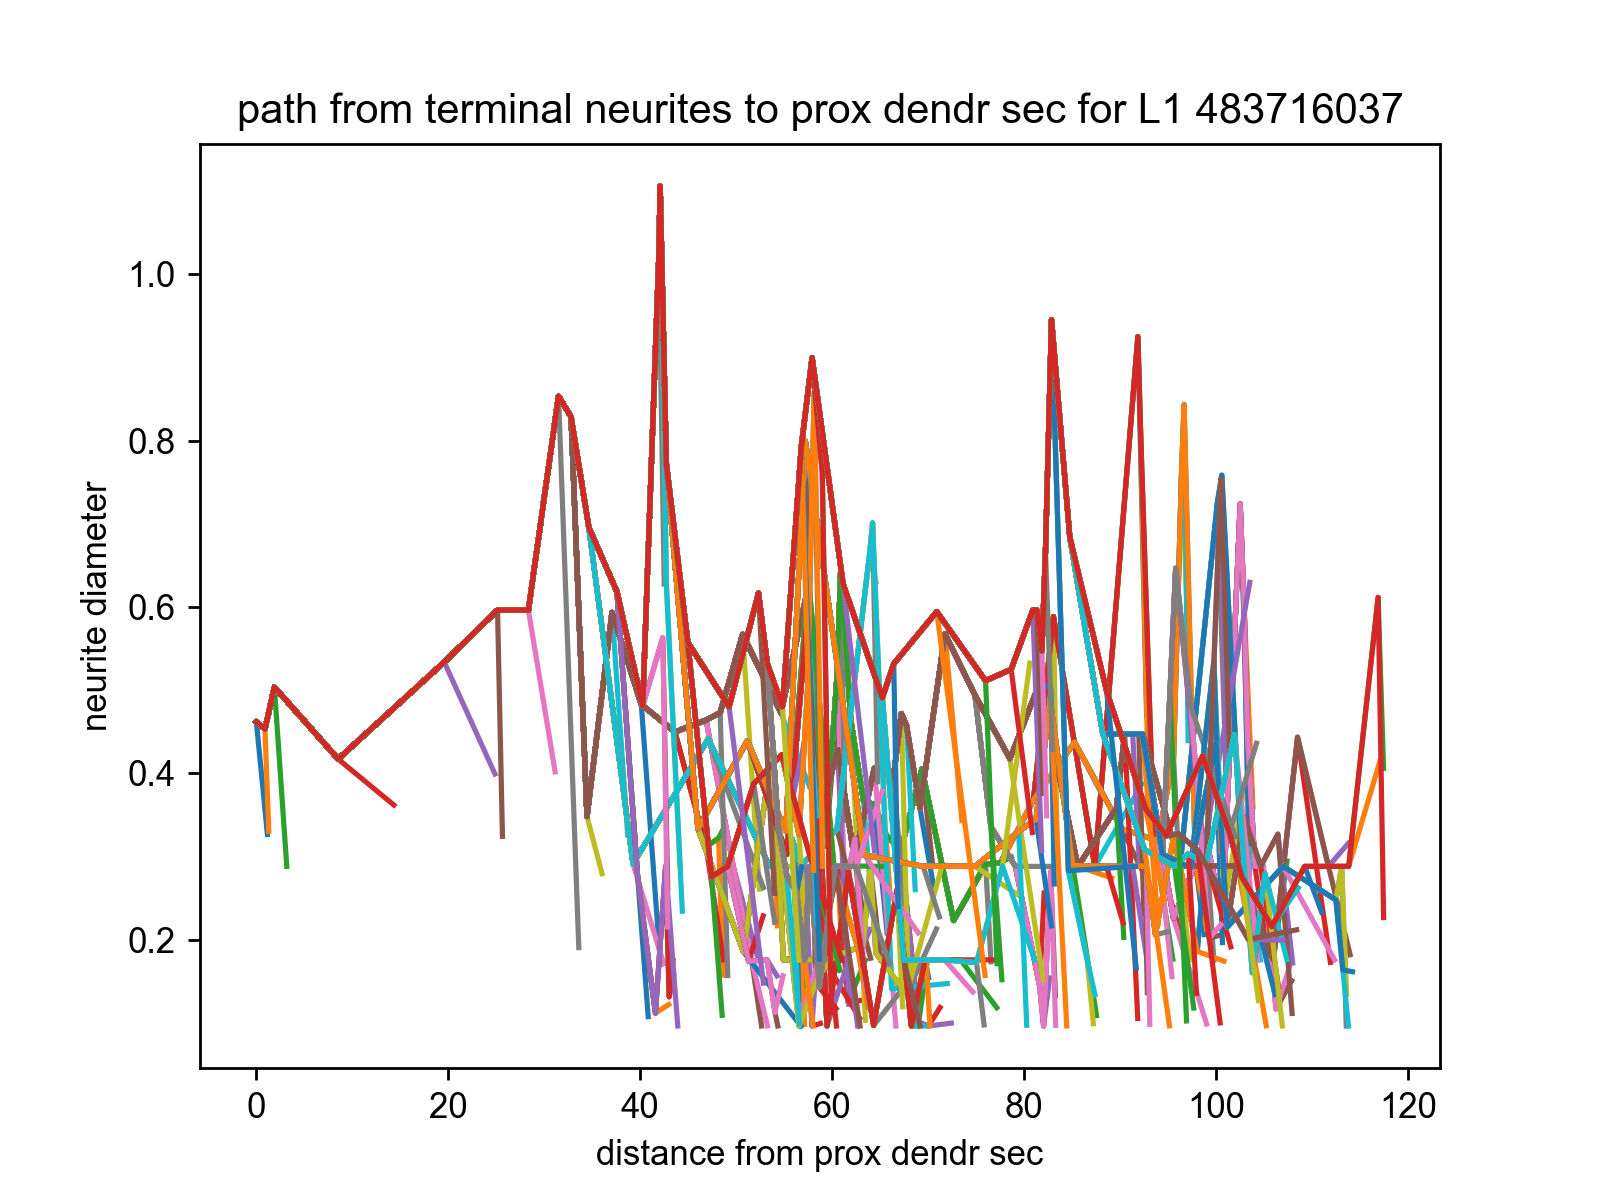
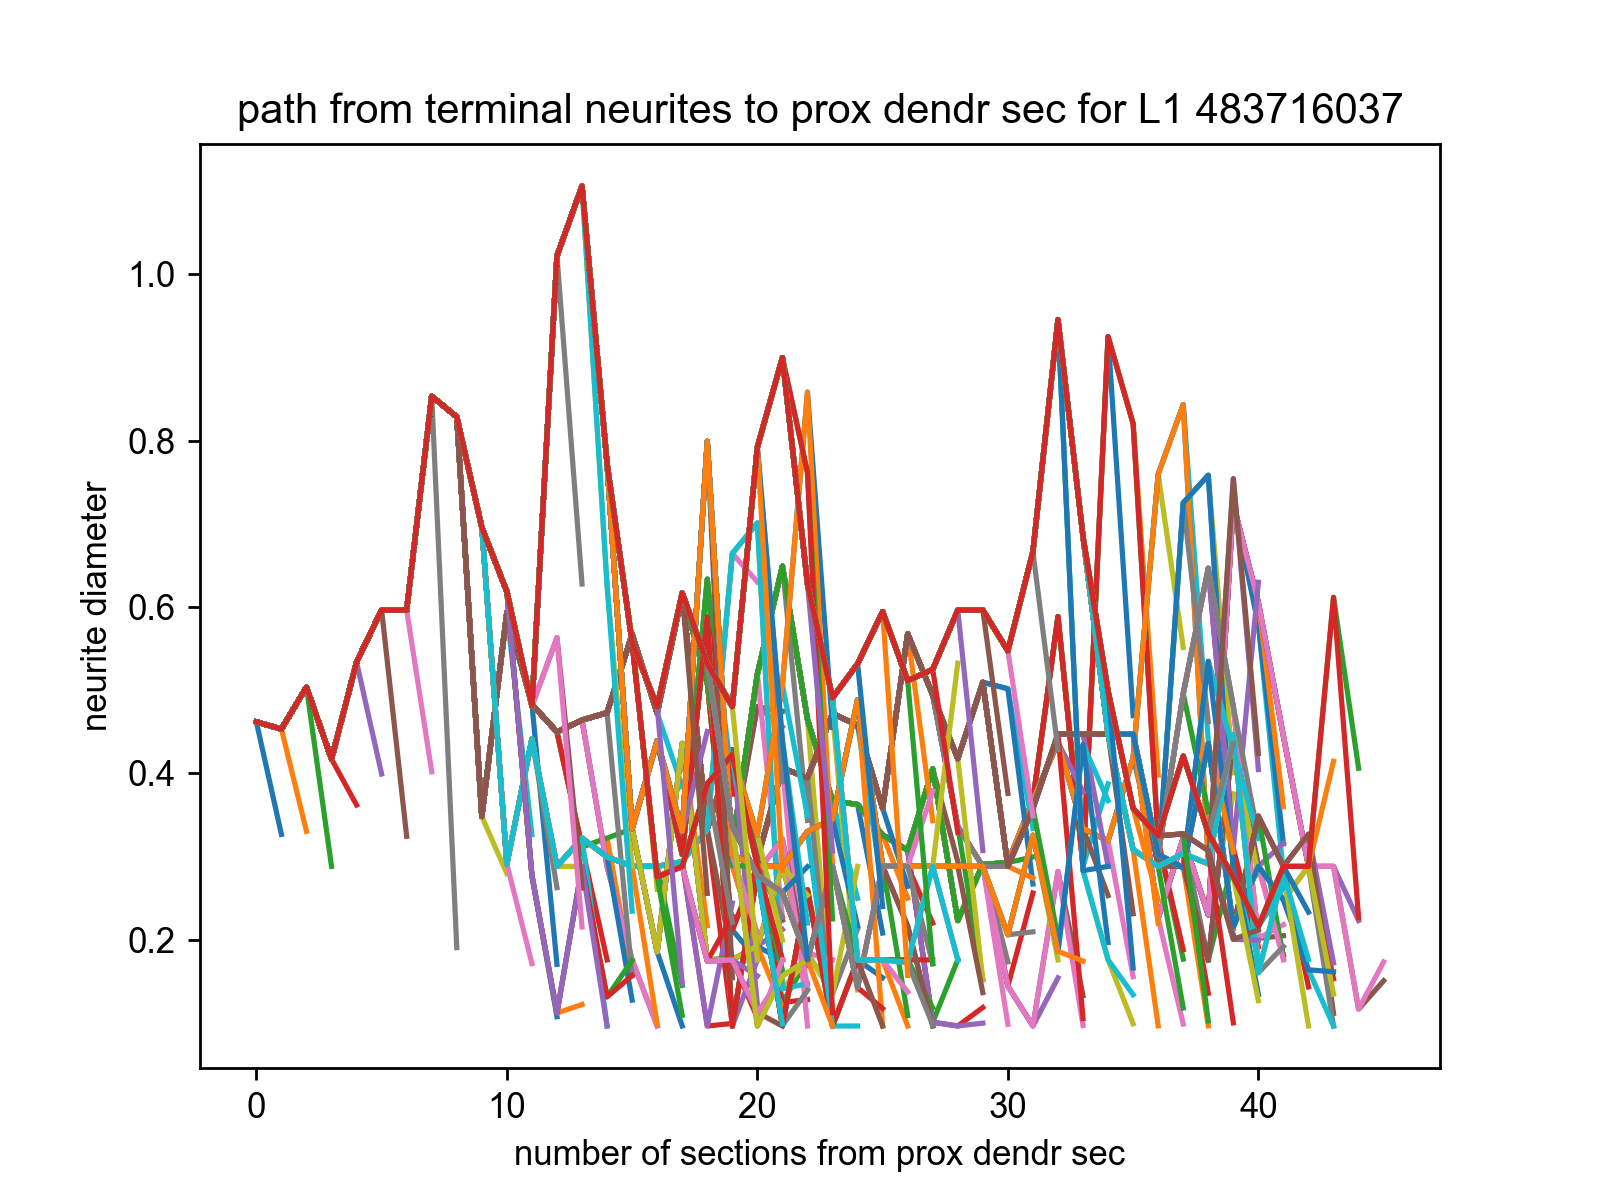